In [1]:
# ================================
# Cocoa Pod and flower Detection & Counting
# Faster R-CNN + Visualization
# ================================

!pip install torch torchvision matplotlib --quiet

In [2]:
import os
import torch
import torchvision
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from PIL import Image, ImageDraw
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


✅ Found 50 training images.

--- Visualizing One Training Sample ---


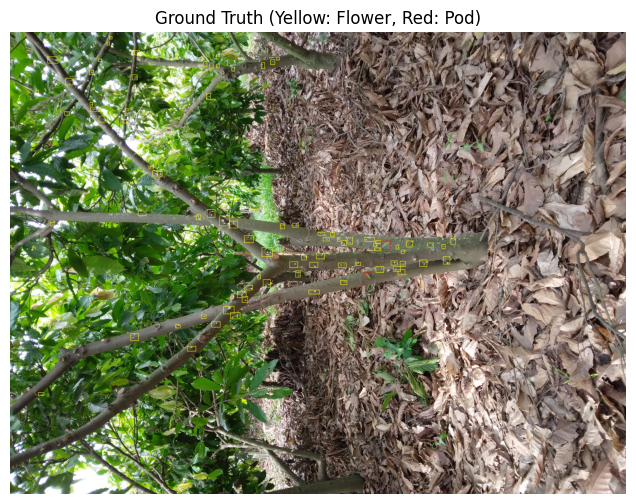


--- Starting Training ---
Training on cuda for 100 epochs...
Epoch 1/100 | Train Loss: 1.7538 | Val Avg Detections: 0.00 | Time: 0m 50s
Epoch 2/100 | Train Loss: 1.2884 | Val Avg Detections: 0.00 | Time: 0m 49s
Epoch 3/100 | Train Loss: 1.1967 | Val Avg Detections: 0.00 | Time: 0m 49s
Epoch 4/100 | Train Loss: 1.2194 | Val Avg Detections: 0.00 | Time: 0m 50s
Epoch 5/100 | Train Loss: 1.1728 | Val Avg Detections: 2.73 | Time: 0m 50s
Epoch 6/100 | Train Loss: 1.1228 | Val Avg Detections: 0.59 | Time: 0m 50s
Epoch 7/100 | Train Loss: 1.1244 | Val Avg Detections: 44.27 | Time: 0m 50s
Epoch 8/100 | Train Loss: 1.2454 | Val Avg Detections: 9.82 | Time: 0m 50s
Epoch 9/100 | Train Loss: 1.0603 | Val Avg Detections: 11.41 | Time: 0m 50s
Epoch 10/100 | Train Loss: 1.0322 | Val Avg Detections: 11.77 | Time: 0m 50s
Epoch 11/100 | Train Loss: 1.0505 | Val Avg Detections: 19.36 | Time: 0m 49s
Epoch 12/100 | Train Loss: 0.9713 | Val Avg Detections: 15.14 | Time: 0m 50s
Epoch 13/100 | Train Loss: 0.9

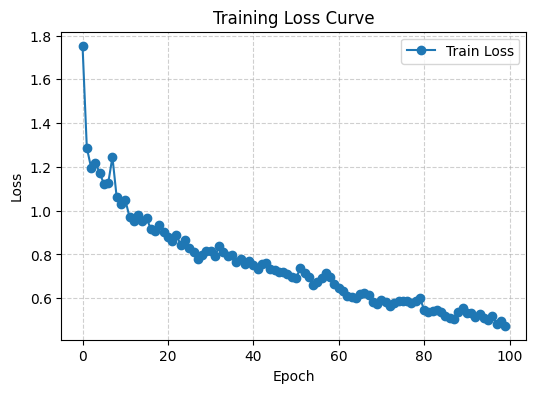

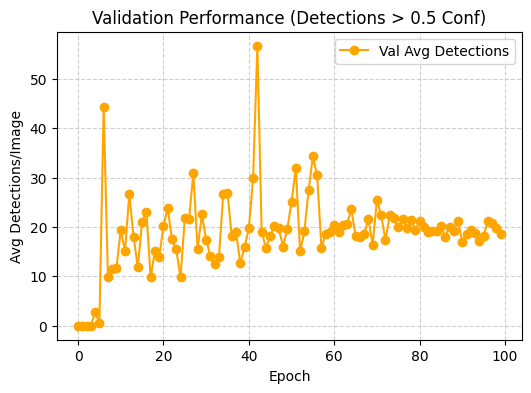


--- Running Evaluation on Test Set ---

===== Model Summary =====
Test images      : 57
Total Flowers    : 623
Total Cocoa Pods : 178
Avg Flowers/img  : 10.93
Avg Pods/img     : 3.12
Avg Confidence   : 0.903

Visualizing prediction for: 1-2.jpg


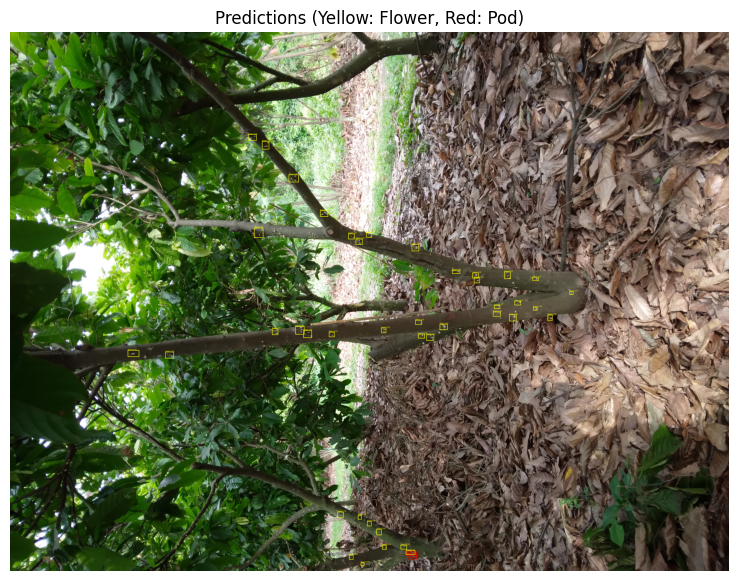

In [ ]:
import os # Moved to top for global availability
from google.colab import drive
import time

# --- Dependencies for VOCDataset and Visualization ---
import torch
import torchvision
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt # Added for visualization
from PIL import Image, ImageDraw # Added ImageDraw for visualization
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader # Added DataLoader import
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor # Added FastRCNNPredictor import
from torchvision.ops import box_iou # Added for calculate_metrics if used later

# 1.--- Configuration for VOCDataset ---
# Class 0: Background (Required by PyTorch)
# Class 1: flower, Class 2: cocoa_pod
CLASS_MAP = {"flower": 1, "cocoa_pod": 2}
NUM_CLASSES = 3

# 2.--- VOCDataset Definition (Duplicated to ensure availability) ---
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, ann_dir, transforms=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transforms = transforms
        self.imgs, self.anns = [], []

        if not os.path.exists(img_dir):
            print(f"⚠️ Warning: Directory {img_dir} not found.")
        else:
            for f in sorted(os.listdir(img_dir)):
                if f.lower().endswith((".jpg",".jpeg",".png")):
                    xml_name = os.path.splitext(f)[0] + ".xml"
                    xml_path = os.path.join(ann_dir, xml_name)
                    if os.path.exists(xml_path):
                        self.imgs.append(f)
                        self.anns.append(xml_name)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        ann_path = os.path.join(self.ann_dir, self.anns[idx])
        img = Image.open(img_path).convert("RGB")

        boxes, labels = [], []
        tree = ET.parse(ann_path)
        root = tree.getroot()

        for obj in root.findall("object"):
            name = obj.find("name").text.strip().lower()
            if name not in CLASS_MAP:
                continue
            label_id = CLASS_MAP[name]

            bnd = obj.find("bndbox")
            xmin = int(float(bnd.find("xmin").text))
            ymin = int(float(bnd.find("ymin").text))
            xmax = int(float(bnd.find("xmax").text))
            ymax = int(float(bnd.find("ymax").text))

            if xmax > xmin and ymax > ymin:
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(label_id)

        # Convert to torch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Handle case where image has no valid objects (ensure empty tensors have correct shapes)
        if boxes.numel() == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx])
        }
        img = F.to_tensor(img)
        return img, target

    def __len__(self):
        return len(self.imgs)

# 3.--- Visualization Helpers (Duplicated to ensure availability) ---
def show_image_with_boxes(img_tensor, target):
    """Show image with ground-truth boxes"""
    img = F.to_pil_image(img_tensor)
    draw = ImageDraw.Draw(img)
    # Colors: Flower = Yellow, Pod = Red
    colors = {1: "yellow", 2: "red"}

    for box, label in zip(target["boxes"], target["labels"]):
        color = colors.get(label.item(), "white")
        draw.rectangle(list(box), outline=color, width=3)

    plt.figure(figsize=(8,6))
    plt.imshow(img)
    plt.title("Ground Truth (Yellow: Flower, Red: Pod)")
    plt.axis("off")
    plt.show()

def show_predictions(img_path, model, score_thr=0.55):
    """Run inference and show predicted boxes"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    img = Image.open(img_path).convert("RGB")
    tens = F.to_tensor(img).to(device)

    with torch.no_grad():
        outputs = model([tens])[0]

    keep = outputs["scores"] >= score_thr
    boxes = outputs["boxes"][keep].cpu().numpy()
    labels = outputs["labels"][keep].cpu().numpy()
    scores = outputs["scores"][keep].cpu().numpy()

    draw = ImageDraw.Draw(img)
    id_to_name = {v: k for k, v in CLASS_MAP.items()}
    colors = {1: "yellow", 2: "red"}

    for box, label, score in zip(boxes, labels, scores):
        name = id_to_name.get(label, "Unknown")
        color = colors.get(label, "lime")
        draw.rectangle(list(box), outline=color, width=3)
        draw.text((box[0], box[1] - 10), f"{name} {score:.2f}", fill=color)

    plt.figure(figsize=(10,7))
    plt.imshow(img)
    plt.title(f"Predictions (Yellow: Flower, Red: Pod)")
    plt.axis("off")
    plt.show()

# 4.--- Model Builder (Duplicated to ensure availability) ---
def build_model(num_classes=3):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(
        in_features, num_classes
    )
    return model

def collate_fn(batch):
    return tuple(zip(*batch))

# 5.--- Training Loop (Duplicated to ensure availability) ---
def train_model(train_imgs, train_labels, valid_imgs, valid_labels, epochs=100, lr=0.005):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1. Setup DataLoaders
    train_ds = VOCDataset(train_imgs, train_labels)
    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=collate_fn)

    # Validation Loader
    valid_ds = VOCDataset(valid_imgs, valid_labels)
    valid_loader = DataLoader(valid_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

    # 2. Setup Model & Optimizer
    model = build_model(num_classes=NUM_CLASSES).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

    # 3. History Tracking
    train_losses = []
    val_counts = []

    print(f"Training on {device} for {epochs} epochs...")

    for epoch in range(epochs):
        start_time = time.time()

        # --- TRAINING PHASE ---
        model.train()
        epoch_loss_sum = 0

        for imgs, tgts in train_loader:
            imgs = [i.to(device) for i in imgs]
            tgts = [{k: v.to(device) for k,v in t.items()} for t in tgts]

            loss_dict = model(imgs, tgts)
            loss = sum(loss_dict.values())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss_sum += loss.item()

        # Calculate avg training loss for this epoch
        avg_train_loss = epoch_loss_sum / len(train_loader)
        train_losses.append(avg_train_loss)

        # --- VALIDATION PHASE (Proxy Metric) ---
        # We calculate the average number of objects detected with >0.5 confidence
        model.eval()
        total_detections = 0
        with torch.no_grad():
            for imgs, _ in valid_loader:
                imgs = [i.to(device) for i in imgs]
                # In eval mode, model returns predictions
                outputs = model(imgs)

                for out in outputs:
                    # Count how many boxes have score > 0.5
                    count = (out["scores"] > 0.5).sum().item()
                    total_detections += count

        # Calculate avg detections per image
        if len(valid_ds) > 0:
            avg_detections = total_detections / len(valid_ds)
        else:
            avg_detections = 0
        val_counts.append(avg_detections)

        # --- LOGGING ---
        end_time = time.time()
        duration = end_time - start_time
        mins, secs = divmod(duration, 60)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Avg Detections: {avg_detections:.2f} | "
              f"Time: {int(mins)}m {int(secs)}s")

    # 6. Save Model
    torch.save(model.state_dict(), "cocoa_flower_model.pth")
    print("Model saved to cocoa_flower_model.pth")

    # -------------------------------
    # 7. Plotting
    # -------------------------------
    # Plot loss curve
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label="Train Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Loss Curve")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # Plot validation detections
    plt.figure(figsize=(6,4))
    plt.plot(val_counts, label="Val Avg Detections", color='orange', marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Avg Detections/Image")
    plt.legend()
    plt.title("Validation Performance (Detections > 0.5 Conf)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    return model

#8. --- Summary Statistics (Duplicated to ensure availability) ---
def summarize_model(model, test_dir, score_thr=0.55):
    """Generate summary statistics on test set"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()

    total_images, total_flowers, total_pods = 0, 0, 0
    all_scores = []

    if not os.path.exists(test_dir):
        print(f"⚠️ Test directory {test_dir} not found.")
        return

    for fn in os.listdir(test_dir):
        if fn.lower().endswith((".jpg",".jpeg",".png")):
            img_path = os.path.join(test_dir, fn)
            img = Image.open(img_path).convert("RGB")
            tens = F.to_tensor(img).to(device)

            with torch.no_grad():
                outputs = model([tens])[0]

            keep = outputs["scores"] >= score_thr
            scores = outputs["scores"][keep].cpu().numpy()
            labels = outputs["labels"][keep].cpu().numpy()

            total_images += 1
            total_flowers += (labels == 1).sum()
            total_pods += (labels == 2).sum()
            all_scores.extend(scores.tolist())

    print("\n===== Model Summary =====")
    print(f"Test images      : {total_images}")
    print(f"Total Flowers    : {total_flowers}")
    print(f"Total Cocoa Pods : {total_pods}")
    if total_images > 0:
        print(f"Avg Flowers/img  : {total_flowers/total_images:.2f}")
        print(f"Avg Pods/img     : {total_pods/total_images:.2f}")
    if all_scores:
        print(f"Avg Confidence   : {sum(all_scores)/len(all_scores):.3f}")
    print("=========================\n")


# -------------------------------
# 9. Run Pipeline (Execution)
# -------------------------------
if __name__ == "__main__":
    # 1. Mount Drive (if in Colab)
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    # 2. Define Paths
    base_dir = "/content/drive/MyDrive/deeplearning/Assignment/augmented_data/output"
    train_imgs = os.path.join(base_dir, "train_images")
    train_labels = os.path.join(base_dir, "train_labels")
    valid_imgs = os.path.join(base_dir, "valid_images")
    valid_labels = os.path.join(base_dir, "valid_labels")
    test_dir = os.path.join(base_dir, "test")

    # 3. Validation Check
    if not os.path.exists(train_imgs) or len(os.listdir(train_imgs)) == 0:
        print("❌ Error: Train directory is empty or does not exist. Check paths.")
    else:
        print(f"✅ Found {len(os.listdir(train_imgs))} training images.")

        # ---------------------------
        # STEP A: Visualize Data
        # ---------------------------
        print("\n--- Visualizing One Training Sample ---")
        sample_ds = VOCDataset(train_imgs, train_labels)
        if len(sample_ds) > 0:
            img, tgt = sample_ds[0]
            show_image_with_boxes(img, tgt)

        # ---------------------------
        # STEP B: Train the Model
        # ---------------------------
        print("\n--- Starting Training ---")
        # Training for 10 epochs (adjust as needed)
        trained_model = train_model(train_imgs, train_labels, valid_imgs, valid_labels, epochs=100)

        # ---------------------------
        # STEP C: Evaluation / Summary
        # ---------------------------
        print("\n--- Running Evaluation on Test Set ---")
        if os.path.exists(test_dir) and len(os.listdir(test_dir)) > 0:
            # 1. Statistical Summary
            summarize_model(trained_model, test_dir, score_thr=0.55)

            # 2. Visual Inference on a random test image
            import random
            test_files = [f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png'))]
            if test_files:
                random_file = random.choice(test_files)
                print(f"Visualizing prediction for: {random_file}")
                show_predictions(os.path.join(test_dir, random_file), trained_model, score_thr=0.45)
        else:
            print("⚠️ Test directory is empty or missing. Skipping evaluation.")



# -------------------------------

In [5]:
# 7. Accuracy / Metric Calculation
# -------------------------------
import torch # Added import

def calculate_metrics(model, data_loader, device, iou_threshold=0.55, score_threshold=0.55):
    """
    Calculates Precision, Recall, and F1-Score based on IoU.
    """
    model.eval()

    # Initialize counters
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    print(f"\n--- Calculating Metrics (IoU Thresh: {iou_threshold}, Score Thresh: {score_threshold}) ---")

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                gt_boxes = targets[i]['boxes'].to(device)
                gt_labels = targets[i]['labels'].to(device)

                # Filter predictions by confidence score
                keep = output['scores'] > score_threshold
                pred_boxes = output['boxes'][keep]
                pred_labels = output['labels'][keep]

                # If no predictions or no ground truth
                if len(pred_boxes) == 0:
                    false_negatives += len(gt_boxes)
                    continue
                if len(gt_boxes) == 0:
                    false_positives += len(pred_boxes)
                    continue

                # Calculate IoU between all pred_boxes and gt_boxes
                # iou_matrix shape: [num_preds, num_gt]
                iou_matrix = box_iou(pred_boxes, gt_boxes)

                # Keep track of which GT boxes have been matched
                gt_matched = torch.zeros(len(gt_boxes), dtype=torch.bool, device=device)

                # Loop through predictions
                for p_idx, p_label in enumerate(pred_labels):
                    # Get IoU scores for this specific prediction against all GTs
                    ious = iou_matrix[p_idx]

                    # Find the max IoU and the index of that GT
                    max_iou, max_idx = torch.max(ious, dim=0)

                    # Check if match is valid
                    if max_iou >= iou_threshold and gt_matched[max_idx] == False:
                        # Check if classes match
                        if p_label == gt_labels[max_idx]:
                            true_positives += 1
                            gt_matched[max_idx] = True # Mark this GT as found
                        else:
                            false_positives += 1 # High IoU but wrong class
                    else:
                        false_positives += 1 # IoU too low or duplicate detection

                # Any GT box not matched is a False Negative
                false_negatives += (len(gt_boxes) - gt_matched.sum().item())

    # --- Final Calculations ---
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall )

    print(f"True Positives : {true_positives}")
    print(f"False Positives: {false_positives}")
    print(f"False Negatives: {false_negatives}")
    print("-" * 30)
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"F1-Score       : {f1_score:.4f}")
    print("-" * 30)

    return precision, recall, f1_score



if __name__ == "__main__":
    # ... (Your existing setup code) ...

    # 1. Define Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 2. Build Dataset for Evaluation
    # Note: We use the VALIDATION set here because it has labels.
    # If your 'test' folder has XML files, create a VOCDataset for it instead.
    eval_ds = VOCDataset(valid_imgs, valid_labels)
    eval_loader = DataLoader(eval_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

    # 3. Load the model (if not already in memory)
    # model = build_model(NUM_CLASSES)
    # model.load_state_dict(torch.load("cocoa_flower_model.pth"))
    # model.to(device)

    # 4. Calculate Accuracy/Metrics
    if len(eval_ds) > 0:
        calculate_metrics(trained_model, eval_loader, device)
    else:
        print("Cannot calculate accuracy: Dataset is empty.")


--- Calculating Metrics (IoU Thresh: 0.55, Score Thresh: 0.45) ---
True Positives : 343
False Positives: 103
False Negatives: 607
------------------------------
Precision      : 0.7691
Recall         : 0.3611
F1-Score       : 0.4914
------------------------------
